In [1]:
from pathlib import Path
from typing import Union, Callable

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as tfk
from sklearn import datasets
from sklearn.externals import joblib
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from dlsvm.models import DnnSvm
from dlsvm.tools import build_model, label_2_pn

In [2]:
out = Path('./0520_digits_svm')
if not out.exists():
    out.mkdir(parents=True)

In [3]:
sns.set()

### Load dataset

In [4]:
digits = datasets.load_digits()

In [5]:
digits = datasets.load_digits()
X = digits.data.astype(np.float32)
y = digits.target.astype(np.float32)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_, X_train_val, y_train_, y_train_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [7]:
y_train_ = label_2_pn(y_train_)
y_train_val = label_2_pn(y_train_val)

### Build model

In [8]:
dlsvm = build_model(
    n_class=len(digits.target_names),
    n_in=len(digits.data[0]),
    n_h=128,
    activation='relu',
    kernel_initializer='he_uniform',
    penalty=1.,
    softmax=False
)

In [9]:
batch_size = 64
epochs = 50
learning_rate = 1e-3
patience = 5
loss = dlsvm.loss_l2_svm

In [10]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
dlsvm.compile(optimizer=optimizer, loss=loss, metrics=['acc'])

In [11]:
es_cb = tfk.callbacks.EarlyStopping(
    monitor='val_loss', patience=patience, mode='auto'
)
tb_cb = tfk.callbacks.TensorBoard(log_dir=str(out))
cl_cb = tfk.callbacks.CSVLogger(
    str(out.joinpath('train.log.csv')), separator=',', append=False
)
cp_cb = tfk.callbacks.ModelCheckpoint(
    str(out.joinpath('model.weights.h5')), monitor='val_acc', verbose=0,
    save_best_only=True, save_weights_only=False, mode='auto', period=1
)

### Train model

In [12]:
history = dlsvm.fit(
    *(X_train_, y_train_),
    validation_data=(X_train_val, y_train_val),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[tb_cb, cl_cb, cp_cb]
)

Train on 1149 samples, validate on 288 samples
Epoch 1/50
1149/1149 [==============================] - 1s 1ms/sample - loss: 9.0190 - acc: 0.0844 - val_loss: 4.7147 - val_acc: 0.2049
Epoch 2/50
1149/1149 [==============================] - 0s 161us/sample - loss: 2.9004 - acc: 0.2889 - val_loss: 2.1549 - val_acc: 0.3889
Epoch 3/50
1149/1149 [==============================] - 0s 135us/sample - loss: 1.4666 - acc: 0.5440 - val_loss: 1.3931 - val_acc: 0.5799
Epoch 4/50
1149/1149 [==============================] - 0s 147us/sample - loss: 0.9375 - acc: 0.6614 - val_loss: 1.0115 - val_acc: 0.6562
Epoch 5/50
1149/1149 [==============================] - 0s 146us/sample - loss: 0.6700 - acc: 0.7433 - val_loss: 0.8146 - val_acc: 0.7118
Epoch 6/50
1149/1149 [==============================] - 0s 108us/sample - loss: 0.5119 - acc: 0.8007 - val_loss: 0.6764 - val_acc: 0.7431
Epoch 7/50
1149/1149 [==============================] - 0s 142us/sample - loss: 0.4010 - acc: 0.8312 - val_loss: 0.5531 - val_a

In [13]:
df_result = pd.DataFrame(history.history)

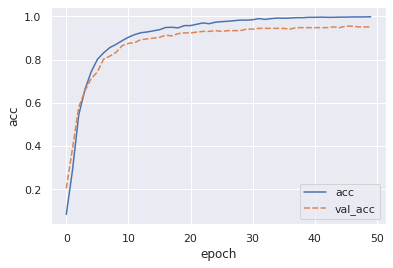

In [14]:
sns.lineplot(data=df_result[['acc', 'val_acc']])
plt.xlabel('epoch')
plt.ylabel('acc')
plt.savefig(out.joinpath('acc_logs.pdf'))

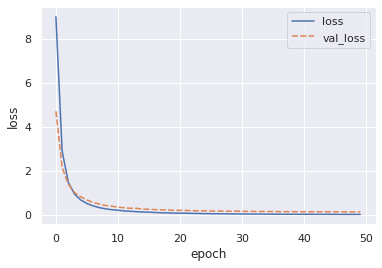

In [15]:
sns.lineplot(data=df_result[['loss', 'val_loss']])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.savefig(out.joinpath('loss_logs.pdf'))

In [16]:
dlsvm.load_weights(str(out.joinpath('model.weights.h5')))

In [17]:
dlsvm.model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               8320      
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 9,610
Trainable params: 9,610
Non-trainable params: 0
_________________________________________________________________


### Performance of model

In [18]:
df_train = pd.DataFrame(
    classification_report(y_pred=np.argmax(dlsvm.predict(X_train), axis=-1), y_true=y_train, output_dict=True)
)
print('Train perfomance of model')
print(df_train)
df_train.to_csv(out.joinpath('train-performance.csv'))

Train perfomance of model
             0.0         1.0         2.0         3.0         4.0         5.0  \
f1-score     1.0    0.984026    0.993007    0.986667    0.992537    0.988930   
precision    1.0    0.968553    1.000000    0.980132    1.000000    0.985294   
recall       1.0    1.000000    0.986111    0.993289    0.985185    0.992593   
support    145.0  154.000000  144.000000  149.000000  135.000000  135.000000   

                  6.0        7.0         8.0         9.0    micro avg  \
f1-score     0.996564    0.97931    0.989547    0.978417     0.988866   
precision    1.000000    0.97931    0.993007    0.985507     0.988866   
recall       0.993151    0.97931    0.986111    0.971429     0.988866   
support    146.000000  145.00000  144.000000  140.000000  1437.000000   

             macro avg  weighted avg  
f1-score      0.988900      0.988877  
precision     0.989180      0.988988  
recall        0.988718      0.988866  
support    1437.000000   1437.000000  


In [19]:
df_test = pd.DataFrame(
    classification_report(y_pred=np.argmax(dlsvm.predict(X_test), axis=-1), y_true=y_test, output_dict=True)
)
print('Test perfomance of model')
print(df_test)
df_test.to_csv(out.joinpath('test-performance.csv'))

Test perfomance of model
                 0.0        1.0        2.0        3.0   4.0        5.0  \
f1-score    0.953846   0.947368   0.970588   0.971429   1.0   0.967742   
precision   0.968750   0.931034   0.942857   0.944444   1.0   0.978261   
recall      0.939394   0.964286   1.000000   1.000000   1.0   0.957447   
support    33.000000  28.000000  33.000000  34.000000  46.0  47.000000   

                 6.0        7.0        8.0        9.0   micro avg   macro avg  \
f1-score    0.971429   0.970588   0.931034   0.962025    0.966667    0.964605   
precision   0.971429   0.970588   0.964286   0.974359    0.966667    0.964601   
recall      0.971429   0.970588   0.900000   0.950000    0.966667    0.965314   
support    35.000000  34.000000  30.000000  40.000000  360.000000  360.000000   

           weighted avg  
f1-score       0.966548  
precision      0.967068  
recall         0.966667  
support      360.000000  


In [20]:
np.argmax(dlsvm.predict(X_train), axis=-1)

array([6, 0, 0, ..., 2, 7, 1])

In [21]:
np.argmax(dlsvm.predict(X_test), axis=-1)

array([6, 9, 3, 7, 2, 1, 5, 2, 5, 2, 1, 9, 4, 0, 4, 2, 3, 7, 8, 8, 4, 3,
       9, 7, 5, 6, 3, 5, 6, 3, 4, 9, 1, 4, 4, 6, 9, 4, 7, 6, 6, 9, 1, 3,
       6, 1, 3, 0, 6, 5, 5, 1, 9, 5, 6, 0, 9, 0, 0, 1, 2, 4, 5, 2, 4, 5,
       7, 0, 7, 5, 9, 3, 5, 4, 7, 0, 4, 5, 5, 9, 9, 0, 2, 3, 8, 0, 6, 4,
       4, 9, 1, 2, 8, 3, 5, 2, 9, 0, 4, 4, 4, 3, 5, 3, 1, 3, 5, 9, 4, 2,
       7, 7, 4, 4, 1, 9, 2, 7, 8, 7, 2, 6, 9, 4, 2, 7, 2, 7, 5, 8, 7, 5,
       7, 9, 0, 6, 6, 4, 2, 8, 0, 9, 4, 6, 9, 9, 6, 9, 0, 3, 5, 6, 6, 0,
       6, 4, 3, 9, 3, 9, 7, 2, 3, 0, 4, 5, 3, 6, 5, 7, 9, 8, 4, 2, 1, 3,
       7, 7, 2, 2, 3, 9, 8, 0, 3, 2, 2, 5, 6, 9, 9, 4, 1, 5, 4, 2, 3, 6,
       4, 8, 5, 9, 5, 7, 8, 9, 4, 8, 1, 5, 4, 4, 9, 6, 1, 8, 6, 0, 4, 5,
       2, 7, 4, 6, 4, 5, 6, 0, 3, 2, 3, 6, 7, 1, 5, 1, 4, 7, 6, 5, 1, 5,
       5, 1, 0, 2, 8, 8, 9, 9, 7, 6, 2, 2, 2, 3, 4, 8, 1, 3, 6, 0, 9, 7,
       7, 0, 1, 0, 4, 5, 8, 5, 3, 6, 0, 4, 1, 0, 0, 3, 6, 5, 9, 7, 3, 5,
       5, 9, 9, 8, 5, 3, 3, 2, 0, 5, 8, 3, 4, 0, 2,